<div class="alert alert-block alert-info">
Author:<br>Felix Gonzalez, P.E. <br> Adjunct Instructor, <br> Division of Professional Studies <br> Computer Science and Electrical Engineering <br> University of Maryland Baltimore County <br> fgonzale@umbc.edu
</div>

# NLP Text Clustering Notebook

The objective of this Jupyter Notebook is to provide an example of how text clustering works as well as expected outputs, and how they can be utilized.

# Table of Contents
[Text Clustering](#Text-Clustering)

[Data Loading](#Data-Loading)

[Data Filtering in Preparation for Clustering](#Data-Filtering-in-Preparation-for-Clustering)

[Bag of Words (BoW) Model](#Bag-of-Words-(BoW)-Model)

[Dimensionality Reduction](#Dimensionality-Reduction)

- [PCA Function](#PCA-Function)

- [TSNE Function](#TSNE-Function)

[Other Functions](#Other-Functions)

[Clustering Algorithms](#Clustering-Algorithms)

[KMeans](#KMeans)

- [KMeans: Assignment of Clusters to Records](#KMeans:-Assignment-of-Clusters-to-Records)

- [KMeans: Cluster Counts](#KMeans:-Cluster-Counts)

- [Kmeans: Topics within Each Cluster](#Kmeans:-Topics-within-Each-Cluster)

- [Kmeans: Visualizing Clusters](#Kmeans:-Visualizing-Clusters)

[DBSCAN](#DBSCAN)

- [DBSCAN: Assignment of Clusters to Records](#DBSCAN:-Assignment-of-Clusters-to-Records)

- [DBSCAN: Cluster Counts](#DBSCAN:-Cluster-Counts)

- [DBSCAN: Topics within Each Cluster](#DBSCAN:-Topics-within-Each-Cluster)

- [DBSCAN: Visualizing Clusters](#DBSCAN:-Visualizing-Clusters)

In [1]:
import os
os.environ["OMP_NUM_THREADS"] = '1' # Resolves warning on KMeans memory leak. Needs to be done before importing KMeans.

In [2]:
import pandas as pd
import numpy as np
from numpy import unique, where
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os # To open Excel file in function

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer  # For bag of words.
from sklearn.metrics import silhouette_samples, silhouette_score # Metrics for determining optimal parameters.
from sklearn.decomposition import PCA # used for PCA Dimensionality Reduction
from sklearn.manifold import TSNE # used for TSNE Dimensionality Reduction
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler, MinMaxScaler # Used for scaling data

from sklearn import cluster # K-Means characteristics
from sklearn.cluster import KMeans # K-Means
from sklearn.cluster import DBSCAN # DBSCAN

from scipy.spatial.distance import cdist

import seaborn as sns # Visualization library.

# Text Clustering
[Return to Table of Contents](#Table-of-Contents)

Clustering is part of unsupervised machine learning (ML). When  applying clustering algorithms to text data (i.e., combined with Natural Language Processing (NLP)), the objective is to use the text words, terms, and tokens to be able to create useful and signficant clusters. In such case we can use the vectors that are created in one of the NLP models (e.g., bag of words). Once the clusters are created each individual cluster and its respective words, terms, and tokens can be evaluated individually.  

References and articles on Text Clustering:
-  Text Clustering with K-Means https://medium.com/@lucasdesa/text-clustering-with-k-means-a039d84a941b- # KMeans Clustering Metrics https://towardsdatascience.com/clustering-metrics-better-than-the-elbow-method-6926e1f723a- 
- KMeans Clustering Metrics Code https://github.com/tirthajyoti/Machine-Learning-with-Python/blob/master/Clustering-Dimensionality-Reduction/Clustering_metrics.ipy- 
- Using TSNE https://distill.pub/2016/misread-t-e/
- High Dimension Clustering w/ t-SNE & DBSCAN https://link.medium.com/zNc9Q- j0cb
- High Dimension Clustering w/ t-SNE & DBSCAN https://github.com/dougfoo/machineLearning/blob/master/covid/COVID-global-clustering.ipynb

# Data Loading
[Return to Table of Contents](#Table-of-Contents)

In this example we will continue to use the News Article dataset and the NLP fucntions (e.g., for text normalization) discussed in the  notebook "28_Natural_Language_Processing_Introduction.ipynb". One note about text clustering is that we will need to evaluate the resulting terms, words, and tokens and in this case it is recommended to use lemmatization as the results will be more understandable and readable. In the case of stemming, the terms, words, and tokens are not always readable which is a disadvantage in this case.

In [3]:
# Read dataframe.
df = pd.read_csv(r'.\output_data\df_norm_text.csv', 
                 parse_dates= ['Date'],
                 date_format= '%Y-%m-%d %I-%p')

In [4]:
print(df.shape)
df.columns

(2692, 6)


Index(['Article', 'Date', 'Heading', 'NewsType', 'norm_text_wlemma',
       'norm_text_wstemming'],
      dtype='object')

In [5]:
df['Date'] = pd.to_datetime(df['Date'], format='%m/%d/%Y')

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2692 entries, 0 to 2691
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   Article              2692 non-null   object        
 1   Date                 2692 non-null   datetime64[ns]
 2   Heading              2692 non-null   object        
 3   NewsType             2692 non-null   object        
 4   norm_text_wlemma     2692 non-null   object        
 5   norm_text_wstemming  2692 non-null   object        
dtypes: datetime64[ns](1), object(5)
memory usage: 126.3+ KB


In [7]:
min_date = df['Date'].min()
max_date = df['Date'].max()
print(f'The data range goes from {min_date} to {max_date}.')

The data range goes from 2015-01-01 00:00:00 to 2017-03-27 00:00:00.


In [8]:
np.array(['2015-01-01'], dtype = 'datetime64')

array(['2015-01-01'], dtype='datetime64[D]')

In [9]:
df['NewsType'].value_counts()

NewsType
sports      1408
business    1284
Name: count, dtype: int64

# Data Filtering in Preparation for Clustering
[Return to Table of Contents](#Table-of-Contents)

In this example let's explore what clusters results when we filter the data for the data of calendar year 2015-2016 and the News Types related to sports. This should give us a better idea of what type of sport topics are discussed within the articles in the data. 

Note that we can slice the data in whatever ways we wante (e.g., select business news types, calendar year 2016, all the data, etc.).  To accomplish this we first need to filter the data for those specific filters and groups. The algorithm will then proceed to read the articles and given the text that it is seeing cluster/group the data appropriately. 

In [10]:
# Filtering the DF to filter by date.  Lets pick Calendar Year 2015-2016 data points.
df_filtered = df[(df['Date'] >= '2015-01-01') & 
                 (df['Date'] <= '2016-12-31') & 
                 (df['NewsType'] == 'sports')].copy()
df_filtered = df_filtered.reset_index(drop=True) # Need to reset the index otherwise the index of the Bag of Words and the dataframe will not match.
print(df_filtered.shape)
df_filtered.head(1)

(1408, 6)


,Article,Date,Heading,NewsType,norm_text_wlemma,norm_text_wstemming
0,strong>LAHORE: Left arm fast bowler Mohammad A...,2016-01-01,Amir returns to Pakistan squad after 5 year b,sports,strong lahore left arm fast bowler mohammad am...,strong lahor left arm fast bowler mohammad ami...


In [11]:
# We can see the date range selected.
min_date = df_filtered['Date'].min()
max_date = df_filtered['Date'].max()
print(f'The data range goes from {min_date} to {max_date}.')

The data range goes from 2016-01-01 00:00:00 to 2016-08-06 00:00:00.


In [12]:
# We can see the newstype selected.
df_filtered['NewsType'].value_counts()

NewsType
sports    1408
Name: count, dtype: int64

# Bag of Words (BoW) Model
[Return to Table of Contents](#Table-of-Contents)

In this case we will also be using a BoW model to vectorize the words, terms, and tokens that appear in the narratives filtered (i.e., calendar years 2015-2016 and sports news articles). These vecstors will be utilized to perform the clustering.

In [13]:
# Creating BOW for the Target DataFrame

# Defining the TFIDF
vectorizer = TfidfVectorizer(lowercase=True, 
                             analyzer='word', 
                             stop_words = None,
                             ngram_range=(1, 2), 
                             max_df=0.95, 
                             min_df=0.01) # For max_df and min_df explanation https://stackoverflow.com/questions/27697766/understanding-min-df-and-max-df-in-scikit-countvectorizer
bow_array = vectorizer.fit_transform(df_filtered['norm_text_wlemma']).toarray() # Converting the words within the norm_text to an array.

# Returns word vectors.
features = vectorizer.get_feature_names_out()
df_bow = pd.DataFrame(bow_array, columns = features)

Note that because I already processed and normalized the text and removed stopwords I will not need to add a list of stopwords to be utilized in this step. If you want to add a list of stopwords here, it is recommended that youyou utilize the same list that was used in the text normalization columns. Also note that if you define a list of stopwords (e.g., 'english') in the TfidfVectorizer function it will utilize the Scikit Learn library stopword list unless you provide another list (e.g., custom stopwords or NLTK list). If you use the NLTK list in the text normalization and define the 'english' in this function it may cause removal of stopwords from different libraries (e.g., stopwords from NLTK vs. those in SciKit Learn) and may cause some differences that may not be easy to debug.

In [14]:
df_bow.head(3) # Each word was converted to a column and the values are the TFIDF for the index of the record.
# Merging the df_bow and df_filtered will give you all columns together.
# This vectors will be utilized to create clusters.

,aaron,aaron finch,ab,ab de,abandon,abbott,ability,able,absence,abu,...,younis,younis khan,youth,yuvraj,yuvraj singh,zalmi,zealand,zimbabwe,zulfiqar,zulfiqar babar
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.092266,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.098282,0.0,0.0,0.0


In [15]:
df_bow.shape
# The first number is the number of records.  The second number is the number of words.
# Note that the second number is highly dependenton the TfidfVectorizer parameters of ngram_range, max_df and min_df.
# Each of these words/features/terms/tokens now represent a dimension.

(1408, 2833)

# Dimensionality Reduction
[Return to Table of Contents](#Table-of-Contents)

Dimensionality reduction refers to mathematical techniques that convert a multi-dimensional dataset (i.e., more than 3 dimensions) into lower dimension dataset (i.e., 2 or 3-diemnsions). This technique mathematically combines and projects the most important features. Main dimensionality reduction methos include Principal Component Analysis (PCA) and T-distributed Stochastic Neighbor Embedding (TSNE). In both of these cases the algorithms transform a high-dimensional dataset (i.e., several thousands of features as is the case of the BoW matrix above) to two- or three-dimensions. The clusters are then created using the lower dimensional vectors. 

References:
- PCA: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
- TSNE: https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

### PCA Function
[Return to Table of Contents](#Table-of-Contents)

In [16]:
def pca_variance_plot():
    NUM_COMPONENTS = min(df_bow.shape[0], bow_array.shape[1]) # Number of components. Cannot be larger than the number of n_samples or features. df_bow.shape[0] is the number of samples (e.g., records) in the sample. The bow_array.shape[1] is the number of features (terms or words) in the dataframe. 
    pca = PCA(n_components = NUM_COMPONENTS) # Defining the PCA model variable
    bow_array_PCA = pca.fit_transform(bow_array) # The bow_calc_array is the reduced bow array to be used for the calculation of clusters.
    variance_explained = np.cumsum(pca.explained_variance_)
    
    print('''The y-axis is the fraction of cummulative explained variance given the number of components in the x-axis. 
    Ideally we would select the number of components such that we can explain a high number of the variability. 
    For example, if we wanted to explain 80% of the variability we would need number of components that match to 0.8. 
    However, if the result is high may not result in significant dimensionality reduction.''')
    fig, ax = plt.subplots(figsize=(8, 4))
    plt.plot(range(NUM_COMPONENTS),variance_explained, color='r')
    ax.grid(True)
    plt.title(label = f"Cummulative Explained Variance vs. {NUM_COMPONENTS} Components")
    plt.xlabel("Number of components")
    plt.ylabel("Cumulative explained variance")
    plt.show();

The y-axis is the fraction of cummulative explained variance given the number of components in the x-axis. 
    Ideally we would select the number of components such that we can explain a high number of the variability. 
    For example, if we wanted to explain 80% of the variability we would need number of components that match to 0.8. 
    However, if the result is high may not result in significant dimensionality reduction.


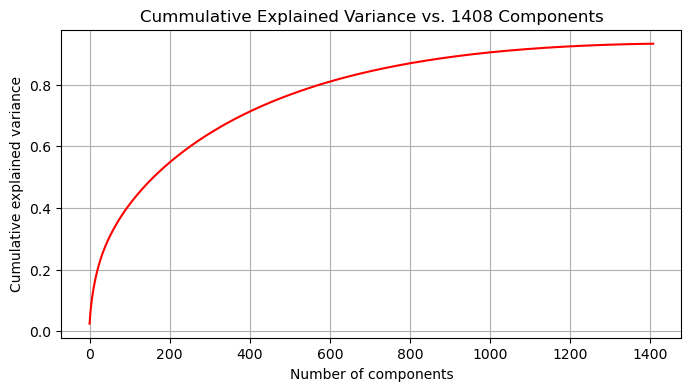

In [17]:
pca_variance_plot()

For simplicity, the PCA Dimensionality Reduction applied here is n_components = 2 (i.e., reduces the dimensions to 2 components). As the plot above explains, 2 dimensions in this case does not provide a high "explainability". On the other hand, 2 dimensions can be visualized in a 2D plot (e.g., scatter plot).

In [18]:
def PCA_func():
    global bow_array_PCA, bow_array_PCA_scaled
    pca = PCA(n_components = 2) # PCA Model with 2 Components
    bow_array_PCA = pca.fit_transform(bow_array) # The bow_calc_array is the reduced bow_array to be used for the calculation of clusters.

    # Projection Plot (scaled) of records in data.
    scaler = MinMaxScaler()
    scaler.fit(bow_array_PCA)
    bow_array_PCA_scaled = scaler.transform(bow_array_PCA)

    # Scatter plot PCS
    plt.scatter(bow_array_PCA[:, 0], bow_array_PCA[:, 1], marker='.', s=30, lw=0, alpha=1, c=None, edgecolor=None)
    plt.title(label = f"PCA (Not Scaled)")
    TSNE_Plot = plt.show()

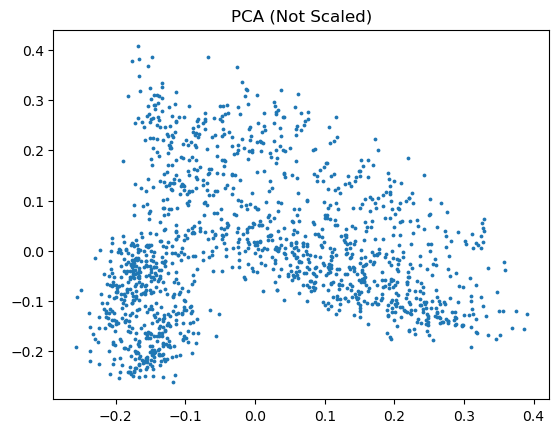

In [19]:
PCA_func()
# The resulting plot is a 2-Dimensional representation of all the dimensions (each word) of the dataset.
# See the references section for more information on PCA.
# Each point in the plot represents a record.

### TSNE Function
[Return to Table of Contents](#Table-of-Contents)

In [20]:
def TSNE_func():
    global perplexity, bow_array_TSNE, TSNE_Plot
    # TSNE with defined perplexity.  The perplexity defines how the TSNE Plot looks and its two main dimensions.  Ideally the user wants separable clusters and would iterate thru different perplexities and select the one with the most defined clusters.  In ORPS case due to the variability of the data (e.g., different filters that could be applied), its high dimensionality and users being SME's in other areas, it would be tough to evaluate and select a perplexity for each unique case.
    perplexity = 30
    bow_array_TSNE = TSNE(n_components=2, perplexity = perplexity, random_state=42, n_iter=5000).fit_transform(bow_array)

    # Projection Plot (scaled) of records in data.
    scaler = MinMaxScaler()
    scaler.fit(bow_array_TSNE)
    bow_array_TSNE_scaled = scaler.transform(bow_array_TSNE)
    
    # Scatter plot TSNE and perplexity
    plt.scatter(bow_array_TSNE[:, 0], bow_array_TSNE[:, 1], marker='.', s=30, lw=0, alpha=1, c=None, edgecolor=None)
    plt.title(label = f"TSNE Perplexity = {perplexity}")
    TSNE_Plot = plt.show()

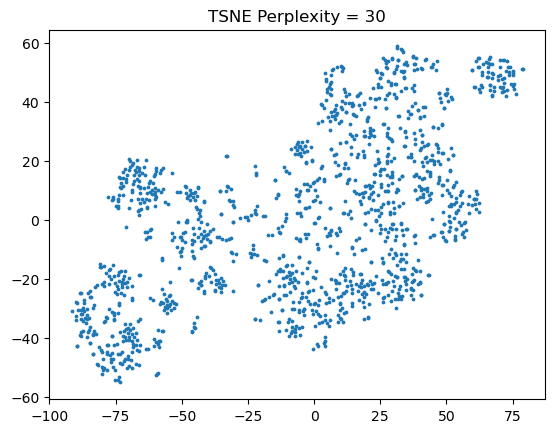

In [21]:
# Running TSNE.  Depending on the amount of data points this might take some time.
TSNE_func()

# The resulting plot is a 2-Dimensional representation of all the dimensions (each word) of the dataset.
# See the references section for more information on TSNE.
# Each point in the plot represents a record.

# Other Functions
[Return to Table of Contents](#Table-of-Contents)

This functions allow to explore the topics within each cluster.

In [30]:
#  Functions for extracting the topics.
def get_top_features_cluster(tf_idf_array, prediction, n_feats):
    labels = np.unique(prediction)
    dfs = []
    for label in labels:
        id_temp = np.where(prediction==label) # indices for each cluster
        x_means = np.mean(tf_idf_array[id_temp], axis = 0) # returns average score across cluster
        sorted_means = np.argsort(x_means)[::-1][:n_feats] # indices with top 20 scores
        features = vectorizer.get_feature_names_out()
        best_features = [(features[i], x_means[i]) for i in sorted_means]
        df = pd.DataFrame(best_features, columns = ['features', 'score'])
        dfs.append(df)
    return dfs

def plotWords(dfs, n_feats):
    plt.figure(figsize=(8, 4))
    for i in range(0, len(dfs)):
        plt.title(("Most Common Words in Cluster {}".format(i+1)), fontsize=10, fontweight='bold')
        # Note that the "dfs" data frame resets its index to 0 hence the correction of the i+1 above.
        sns.barplot(x = 'score' , y = 'features', orient = 'h', data = dfs[i][:n_feats]) 
        plt.show()

# Clustering Algorithms
[Return to Table of Contents](#Table-of-Contents)

This section focuses on using either KMeans or DBSCAN clustering algorithms to create clusters. In both cases the input needed is the BoW matrix data in array format. This means that the input into the clustering algorihtm functions are either of the following objects created above:
- __bow_array__: array of the token vectors without any dimensionality reduction applied. Note that the TfidfVectorizer resulting BoW matrix is already scaled and there is no need to apply scaling.
- __bow_array_PCA__: array of the token vectors with PCA applied
- __bow_array_PCA_scaled__: scaled array of the token vectors with PCA applied
- __bow_array_TSNE__: array of the token vectors with TSNE applied
- __bow_array_TSNE_scaled__: scaled array fo the token vectors with TSNE applied 

In [22]:
# Select vector array to be used for clustering.
# Options: bow_array, bow_array_PCA, bow_array_PCA_scaled, bow_array_TSNE, bow_array_TSNE_scaled
array_to_cluster = bow_array

# KMeans
[Return to Table of Contents](#Table-of-Contents)

KMeans is a centroid based clustering algorithm where a user defines how many number of clusters (groups) the clustering algorithm will divide the data into. The algorithm defines a center for each cluster and iterates thru the vectors of the records until the distances between the records and the cluster centers are optimized. 

Note that in some cases cluster may be improved if the data is scaled, or dimensionality reduction is applied.Scaling of the data.
Dimensionality reduction.
Clustering algorithm parameters such as determination of the optimal number of clusters. Methods include elbow method and silhoutte coefficient.

In [23]:
# Kmeans model
k = 3 # Using 3 clusters
cluster_pred = KMeans(n_clusters=k, random_state=42).fit_predict(array_to_cluster)

In [24]:
# These returns how many of the records are in Clusters 0, 1 and 2.
unique, counts = np.unique(cluster_pred, return_counts=True)
np.asarray((unique, counts)).T

array([[  0, 486],
       [  1, 539],
       [  2, 383]], dtype=int64)

### KMeans: Assignment of Clusters to Records
[Return to Table of Contents](#Table-of-Contents)

In [25]:
df_cluster_label = pd.DataFrame(cluster_pred, columns=['kmeans_cluster_label']) # Model.labels_ gives an array and converting the array to a dataframe.

In [26]:
# Some non-data scientist stakeholders may not understand that Python is a 0 index code and may prefer assigned clusters start at 1 instead of 0.
# This can be accomplished by adding 1 to the assigned clusters where 0 becomes 1, 1 becomes 2, 2 becomes 3, etc.
df_cluster_label['kmeans_cluster_label'] += 1 

In [27]:
# Checks the percent of records assigned to non-zero clusters. 
# For Kmeans this should be 100 percent.
cluster_percent = round(100*(df_cluster_label['kmeans_cluster_label'].astype(bool).sum(axis=0))/(df_cluster_label.shape[0]),1) 
print(f"Number of records assigned to a cluster: {cluster_percent}%")

Number of records assigned to a cluster: 100.0%


In [28]:
df_filtered['cluster_label'] = df_cluster_label # Adding column with cluster_labels to the full dataset dataframe.
df_filtered.head(1)

,Article,Date,Heading,NewsType,norm_text_wlemma,norm_text_wstemming,cluster_label
0,strong>LAHORE: Left arm fast bowler Mohammad A...,2016-01-01,Amir returns to Pakistan squad after 5 year b,sports,strong lahore left arm fast bowler mohammad am...,strong lahor left arm fast bowler mohammad ami...,3


### KMeans: Cluster Counts
[Return to Table of Contents](#Table-of-Contents)

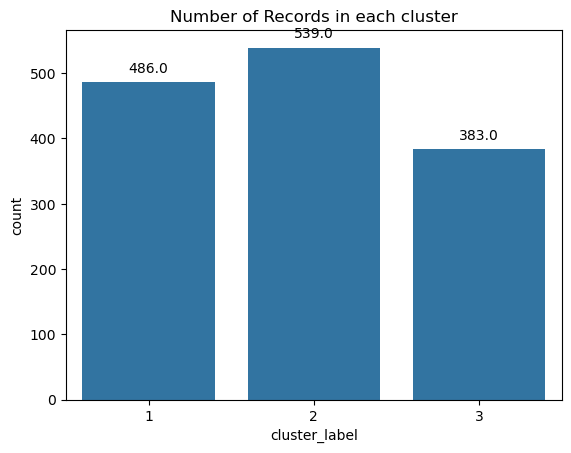

In [34]:
cluster_count_figure = sns.countplot(x='cluster_label', data = df_filtered)
for p in cluster_count_figure.patches:
    cluster_count_figure.annotate(format(p.get_height()),
                                  (p.get_x()+p.get_width()/2, 
                                   p.get_height()), 
                                  ha = 'center', 
                                  va = 'center', 
                                  xytext = (0, 10), 
                                  textcoords = 'offset points')

plt.title(label = f"Number of Records in each cluster")
plt.show()

### Kmeans: Topics within Each Cluster
[Return to Table of Contents](#Table-of-Contents)

After we assign the clusters to each record we can then investigate the score (i.e., TFIDF) of the top tokens in each cluster. This allows us to be able to see the tokens within each clusters, what are the scores, and extract some insights from such results. Note that in the case of Kmeans, there will always be one or two clusters with relatively low scores because Kmeans will force all records into one cluster regardless.

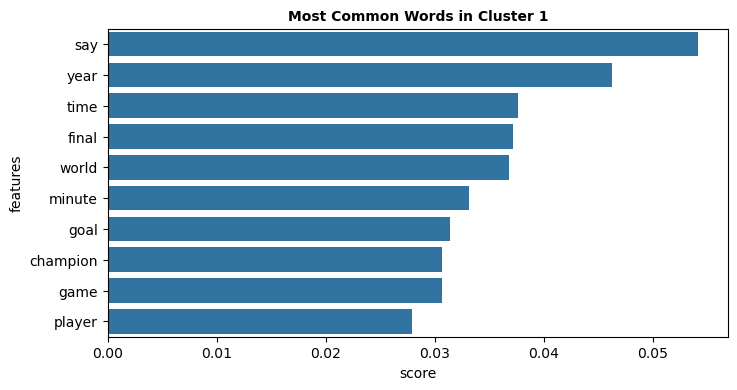

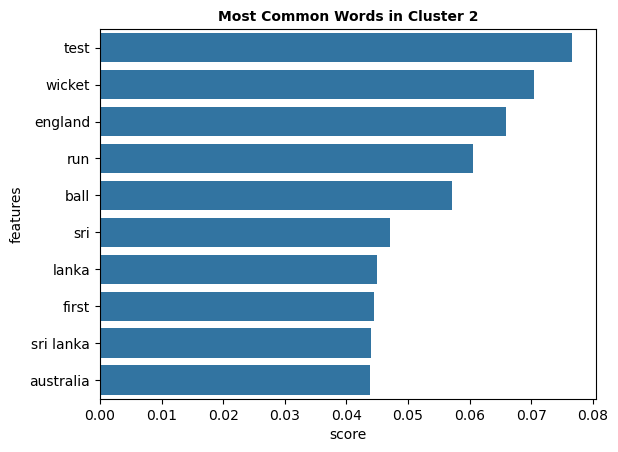

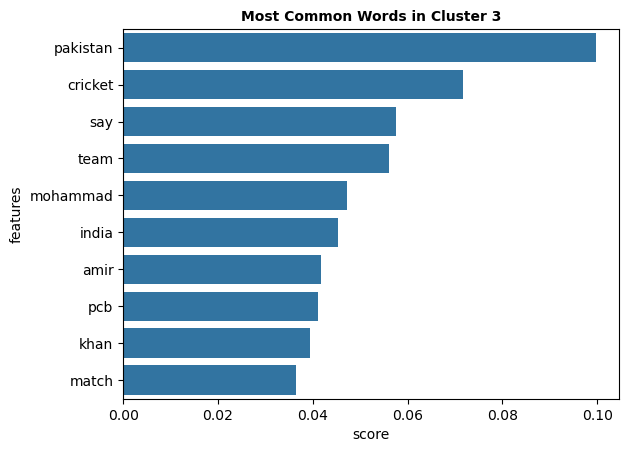

In [31]:
cluster_array = df_filtered["cluster_label"].to_numpy() # Converting cluster_label assigments to an array.
n_feats = 20
dfs = get_top_features_cluster(bow_array, cluster_array, n_feats) # Gets top n_feats (e.g., 20) from the BOW_array.
top_topics = 10
plotWords(dfs, top_topics) # Plots the top_topics up to n_feats.

Notes applicable to running kmeans with array_to_cluster = bow_array:
- Cluster 3 seems to have the token with the highest score. This token is the word "pakistan" with as score of approximately 0.10. Other top tokens within this cluster include the word cricket, other countries where cricket is pracited (e.g., india), the token "pcb" potentially the accronym for "pakistan cricket board".
- Cluster 2 seems to have the
- Tokens in cluster 1 seem to have smaller scores.

Potential modifications: 
- We did not evaluate the optimal number of clusters and using an optimal number of cluster may provide better scores for tokens within the clusters. Potentially using a higher number of k.
- Using a dimensionality reduction may also improve the scores of the words. We may go above and change the array_to_cluster object to use the PCA or TSNE and rerun the code to see if it improves.
- We could add more words to the stopwords. Some words may include countries (i.e., if we are not interested in the clustering algorithm using the country names).
- We could also renumber the clusters so that they are in order of the average of the top 10 token scores. For example, we would calculate the average score of the top 10 scores and we would assign taht cluster cluster 1, cluster 2 the ome with the second average score, and so on. This renumbering would allow us to first see those clusters that may have similar group of reports.

### Kmeans: Visualizing Clusters
[Return to Table of Contents](#Table-of-Contents)

Visualizing the data without dimensionality reduction is not possible as the dataset has too many dimensions. However, we can utilize the clusters and evaluate how the data was clustered using the two dimensions created with the PCA and TSNE. This allows comparing the different arrays and how the would have been visualized within the reduced dimension data.

If the array_to_cluster object utilized was the bow_array the PCA and TSNE would be just a projection of how similar or disimilar the bow_array would cluster within the PCA or TSNE projections. In the case above were we are running kmeans with array_to_cluster = bow_array and k = 3, we can see that the three clusters created without the dimensionality reduction may result in similar clusters when using PCA. TSNE even though similar, one cluster seems to be on top of another.

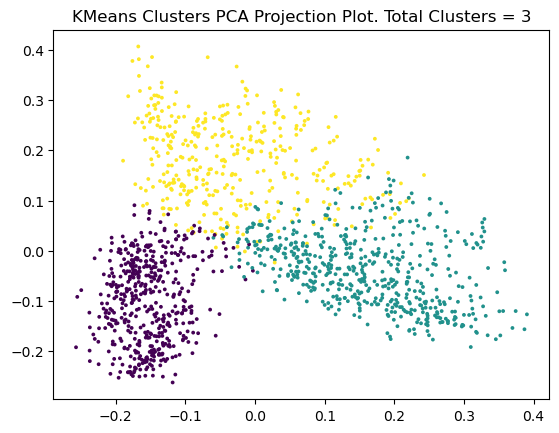

In [32]:
# Scatter plot of the Clusters.  Each color represents a cluster.
# The plot uses the TSNE plot and overimposes the predicted cluster (cluster_pred) over the record points in the TSNE (which recall is a two dimension representation when reducing the dimensionality).
plt.scatter(bow_array_PCA[:, 0], bow_array_PCA[:, 1], marker='.', s=30, lw=0, alpha=1, c=cluster_pred, edgecolor=None)
plt.title(label = f"KMeans Clusters PCA Projection Plot. Total Clusters = {k}")
Cluster_Plot = plt.show()

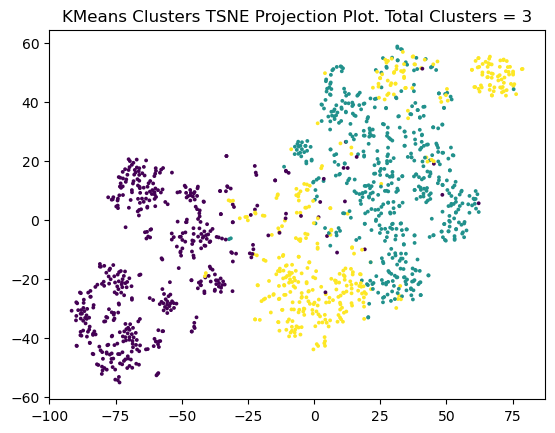

In [33]:
# Scatter plot of the Clusters.  Each color represents a cluster.
# The plot uses the TSNE plot and overimposes the predicted cluster (cluster_pred) over the record points in the TSNE (which recall is a two dimension representation when reducing the dimensionality).
plt.scatter(bow_array_TSNE[:, 0], bow_array_TSNE[:, 1], marker='.', s=30, lw=0, alpha=1, c=cluster_pred, edgecolor=None)
plt.title(label = f"KMeans Clusters TSNE Projection Plot. Total Clusters = {k}")
Cluster_Plot = plt.show()

Note the score, which is the TFIDF score for a specific token within that specific cluster.

# DBSCAN
[Return to Table of Contents](#Table-of-Contents)

DBSCAN is a density based clustering algorithm where a user defines a density or distance parameter called EPS or Epsiloon and a minimum number of samples in a cluster. The DBSCAN clustering algorithm will divide the data into groups given such parameters by iterating through the neighbors of a point in order to identify which meet the parameters and create a cluster.  

Note that in some cases cluster may be improved if the data is scaled, or dimensionality reduction is applied.Scaling of the data. In the case of DBSCAN we need to calculate optimal EPS so that we have a good starting point.

In [38]:
# This code creates the data to determine the optimal density value (EPS). 
neigh = NearestNeighbors(n_neighbors=2) # Defines the model to calculate nearest neighbors.
nbrs = neigh.fit(array_to_cluster) # Fits the data to the model.
distances, indices = nbrs.kneighbors(array_to_cluster) # Calculates the distances
distances = np.sort(distances, axis=0) # Sorts the distances
distances = distances[:,1]

In [39]:
# DataFrame for the "Samples vs. EPS", normalization/scaling and Optimal EPS.

# Creates a dataframe with the distances to be used in the plot.
df_eps_vs_samples = pd.DataFrame(distances, columns=['EPS'])
# Creates a column called "samples" for number of samples
df_eps_vs_samples['samples'] = df_eps_vs_samples.index

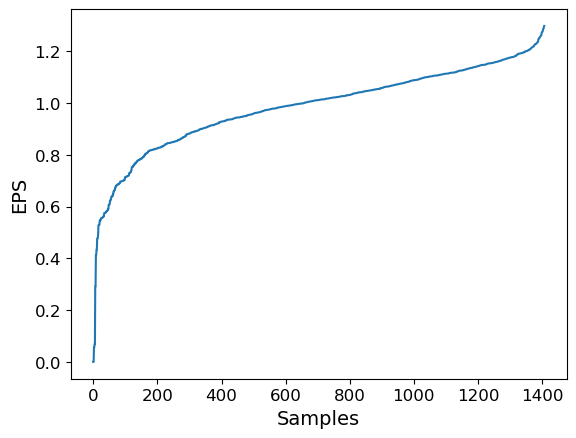

In [40]:
# Plots for EPS vs. the number of samples
plt.plot(distances);
plt.xlabel("Samples", fontsize=14)
plt.xticks(fontsize=12)
plt.ylabel("EPS", fontsize=14)
plt.yticks(fontsize=12)
plt.show();

# The optimal EPS will be at the elbow, knee, inflection or maximum curvature point. In this case may be approximately at 0.8 or 1.2.

In [52]:
# DBSCAN clustering

EPS_value = 1.2 # Start with the estimated Optimal EPS value of 1.2.
min_samples_inacluster = 5 # Minimum number of points for creating a cluster.

# Define the model.  EPS is the max distance between points, and defines the density. 
cluster_pred = DBSCAN(eps= EPS_value, min_samples = min_samples_inacluster).fit_predict(array_to_cluster) 

In [53]:
# These returns how many of the records are in Clusters
unique, counts = np.unique(cluster_pred, return_counts=True)
np.asarray((unique, counts)).T

array([[  -1,   83],
       [   0, 1307],
       [   1,    8],
       [   2,    5],
       [   3,    5]], dtype=int64)

### DBSCAN: Assignment of Clusters to Records
[Return to Table of Contents](#Table-of-Contents)

In [54]:
df_cluster_label = pd.DataFrame(cluster_pred, 
                                columns=['dbscan_cluster_label']) # Model.labels_ gives an array and converting the array to a dataframe.

In [55]:
# Some non-data scientist stakeholders may not understand that Python is a 0 index code and may prefer assigned clusters start at 1 instead of 0.
# This can be accomplished by adding 1 to the assigned clusters where 0 becomes 1, 1 becomes 2, 2 becomes 3, etc.
# In the case of DBSCAN, -1 which represents outliers would be changed to 0.
df_cluster_label['dbscan_cluster_label'] += 1 

In [56]:
# Checks the percent of records assigned to non-zero clusters. 
# For DBSCAN this may be lower than 100 percent as some records may be outliers or noise.
cluster_percent = round(100*(df_cluster_label['dbscan_cluster_label'].astype(bool).sum(axis=0))/(df_cluster_label.shape[0]),1) 
print(f"Number of records assigned to a cluster: {cluster_percent}%")

Number of records assigned to a cluster: 94.1%


In [57]:
df_filtered['cluster_label'] = df_cluster_label # Adding column with cluster_labels to the full dataset dataframe.
df_filtered.head(1)

,Article,Date,Heading,NewsType,norm_text_wlemma,norm_text_wstemming,cluster_label
0,strong>LAHORE: Left arm fast bowler Mohammad A...,2016-01-01,Amir returns to Pakistan squad after 5 year b,sports,strong lahore left arm fast bowler mohammad am...,strong lahor left arm fast bowler mohammad ami...,1


### DBSCAN: Cluster Counts
[Return to Table of Contents](#Table-of-Contents)

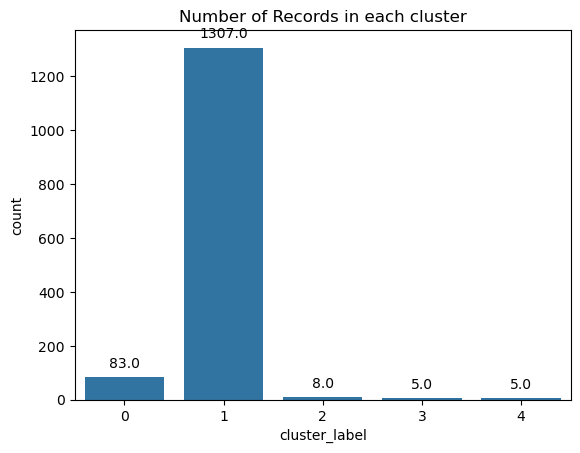

In [48]:
cluster_count_figure = sns.countplot(x='cluster_label', data = df_filtered)
for p in cluster_count_figure.patches:
    cluster_count_figure.annotate(format(p.get_height()),
                                  (p.get_x()+p.get_width()/2, 
                                   p.get_height()), 
                                  ha = 'center', 
                                  va = 'center', 
                                  xytext = (0, 10), 
                                  textcoords = 'offset points')

plt.title(label = f"Number of Records in each cluster")
plt.show()

### DBSCAN: Topics within Each Cluster
[Return to Table of Contents](#Table-of-Contents)

After we assign the clusters to each record we can then investigate the score (i.e., TFIDF) of the top tokens in each cluster. This allows us to be able to see the tokens within each clusters, what are the scores, and extract some insights from such results. Note that in the case of Kmeans, there will always be one or two clusters with relatively low scores because Kmeans will force all records into one cluster regardless.

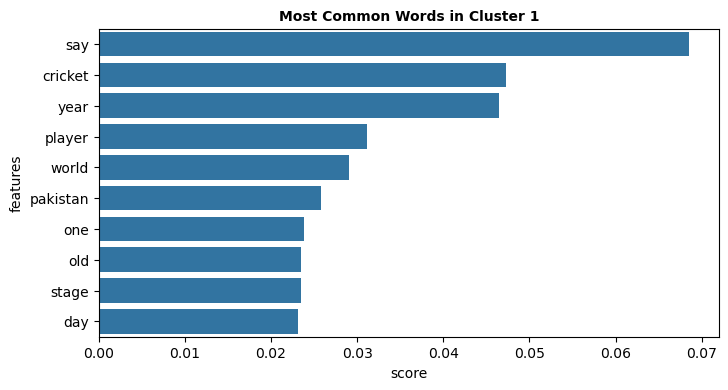

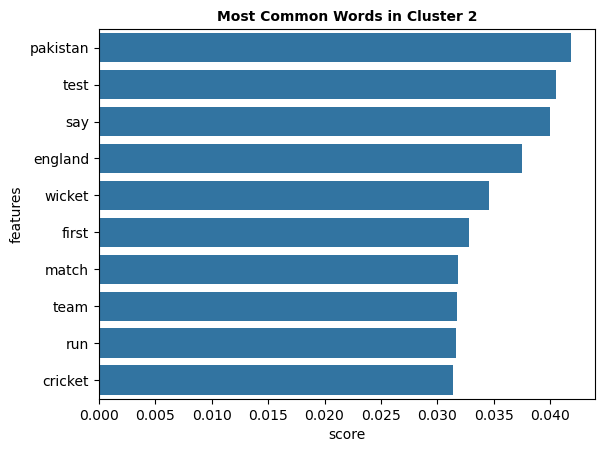

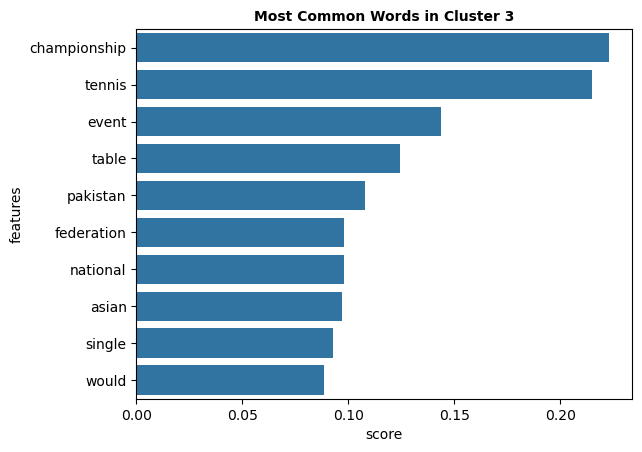

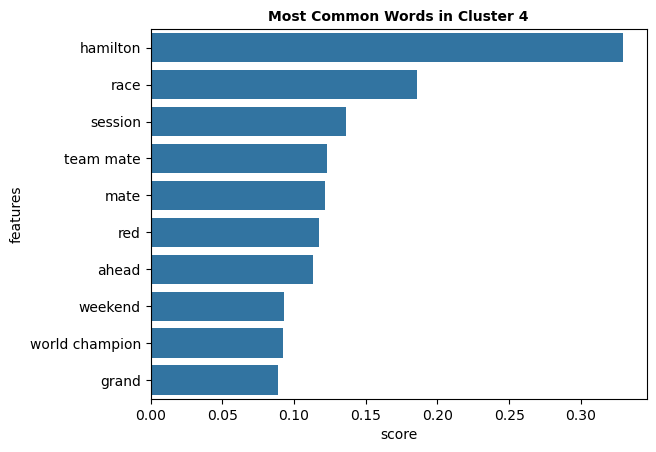

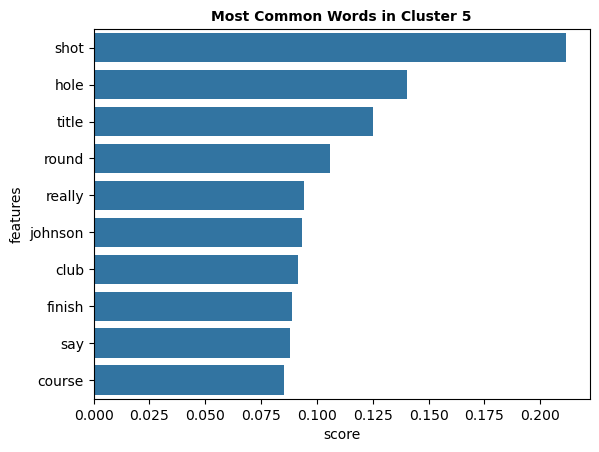

In [49]:
cluster_array = df_filtered["cluster_label"].to_numpy() # Converting cluster_label assigments to an array.
n_feats = 20
dfs = get_top_features_cluster(bow_array, cluster_array, n_feats) # Gets top n_feats (e.g., 20) from the BOW_array.
top_topics = 10
plotWords(dfs, top_topics) # Plots the top_topics up to n_feats.

Notes applicable to running DBSCAN with array_to_cluster = bow_array and :
- The Cluster 2, 3 and 4, even though thy have very few records they resulted in higher scores.

Potential modifications: 
- Using a dimensionality reduction may also improve the scores of the words. We may go above and change the array_to_cluster object to use the PCA or TSNE and rerun the code to see if it improves.
- We could add more words to the stopwords. Some words may include countries (i.e., if we are not interested in the clustering algorithm using the country names).
- We could also renumber the clusters so that they are in order of the average of the top 10 token scores. For example, we would calculate the average score of the top 10 scores and we would assign taht cluster cluster 1, cluster 2 the ome with the second average score, and so on. This renumbering would allow us to first see those clusters that may have similar group of reports.

### DBSCAN: Visualizing Clusters
[Return to Table of Contents](#Table-of-Contents)

We can utilize the clusters and evaluate how the data was clustered using the two dimensions created with the PCA and TSNE. This allows comparing the different arrays and how the would have been visualized in the other dimensions.

If the array_to_cluster object utilized was the bow_array the PCA and TSNE would be just a projection of how similar or disimilar the bow_array would cluster within the PCA or TSNE projections.

In the case above were we are running DBSCAN with array_to_cluster = bow_array and EPS = 1.2 and min_samples_inacluster = 5, we can see that the clusters created without the dimensionality reduction may result in similar clusters when using PCA. TSNE even though similar, one cluster seems to be on top of another.

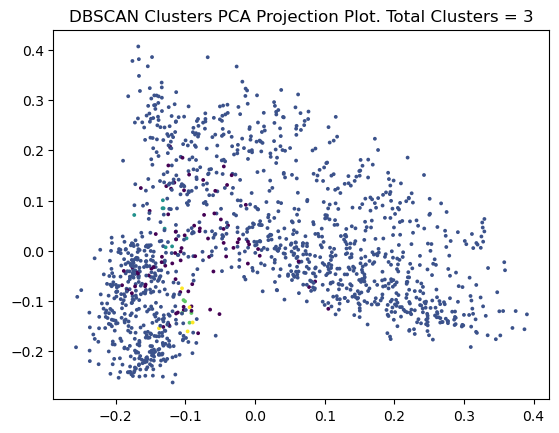

In [50]:
# Scatter plot of the Clusters.  Each color represents a cluster.
# The plot uses the TSNE plot and overimposes the predicted cluster (cluster_pred) over the record points in the TSNE (which recall is a two dimension representation when reducing the dimensionality).
plt.scatter(bow_array_PCA[:, 0], bow_array_PCA[:, 1], marker='.', s=30, lw=0, alpha=1, c=cluster_pred, edgecolor=None)
plt.title(label = f"DBSCAN Clusters PCA Projection Plot.")
Cluster_Plot = plt.show()

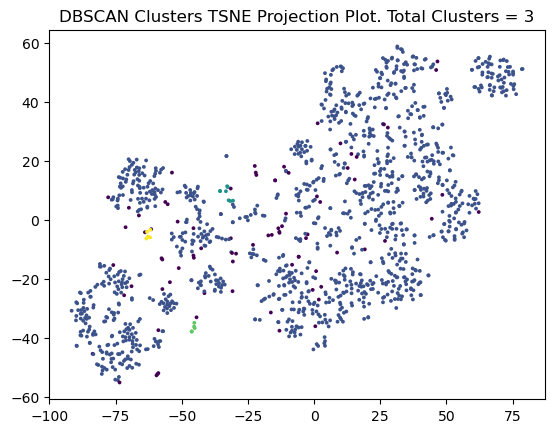

In [51]:
# Scatter plot of the Clusters.  Each color represents a cluster.
# The plot uses the TSNE plot and overimposes the predicted cluster (cluster_pred) over the record points in the TSNE (which recall is a two dimension representation when reducing the dimensionality).
plt.scatter(bow_array_TSNE[:, 0], bow_array_TSNE[:, 1], marker='.', s=30, lw=0, alpha=1, c=cluster_pred, edgecolor=None)
plt.title(label = f"DBSCAN Clusters TSNE Projection Plot.")
Cluster_Plot = plt.show()

# NOTEBOOK END